In [2]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
import os

def list_instruments(data_dir):
    instruments = []
    for label in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, label)
        if os.path.isdir(folder_path):
            instruments.append(label)
    return instruments

data_dir = r'D:\Tag\Musical_Instruments_Classification\music_dataset'
instruments = list_instruments(data_dir)

print("Instruments in the dataset:")
for instrument in instruments:
    print(instrument)


Instruments in the dataset:
Accordion
Acoustic_Guitar
Banjo
Bass_Guitar
Clarinet
cowbell
Cymbals
Dobro
Drum_set
Electro_Guitar
Floor_Tom
flute
Harmonica
Harmonium
Hi_Hats
Horn
Keyboard
Mandolin
Organ
Piano
Saxophone
Shakers
Tambourine
Trombone
Trumpet
Ukulele
vibraphone
Violin


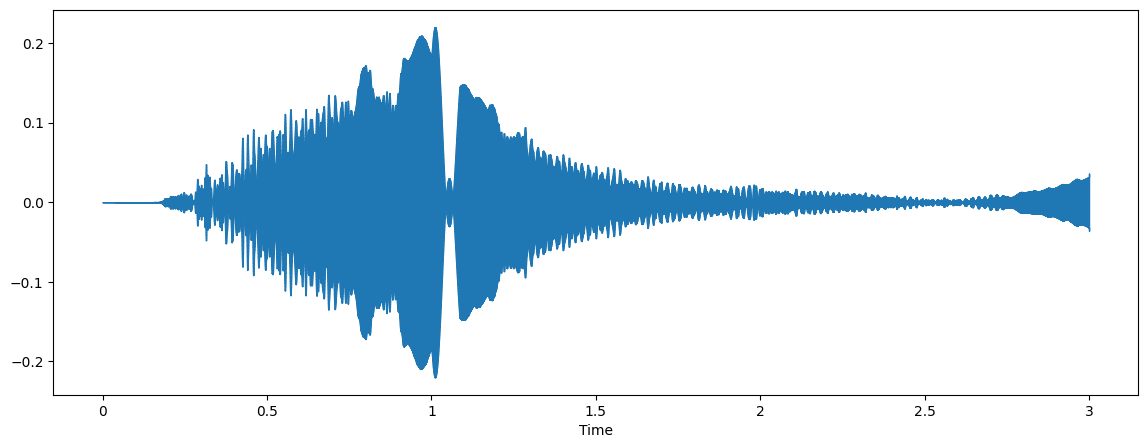

In [4]:
# Load an example audio file
random_file_name = r"D:\Tag\Musical_Instruments_Classification\music_dataset\Electro_Guitar\1.wav"
x, sr = librosa.load(random_file_name, sr=44100)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
plt.show()

In [5]:
# Define function to plot Mel spectrogram
def plot_melspectrogram(y, sr):
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()
    plt.show()

In [6]:
# Plot spectrogram of chunks
def plot_melspectrogram_chunks(y, sr):
    chunk_duration = 4  # seconds
    overlap_duration = 2  # seconds
    chunk_samples = chunk_duration * sr
    overlap_samples = overlap_duration * sr
    num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

    for i in range(num_chunks):
        start = i * (chunk_samples - overlap_samples)
        end = start + chunk_samples
        chunk = y[start:end]
        mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        plt.tight_layout()
        plt.show()

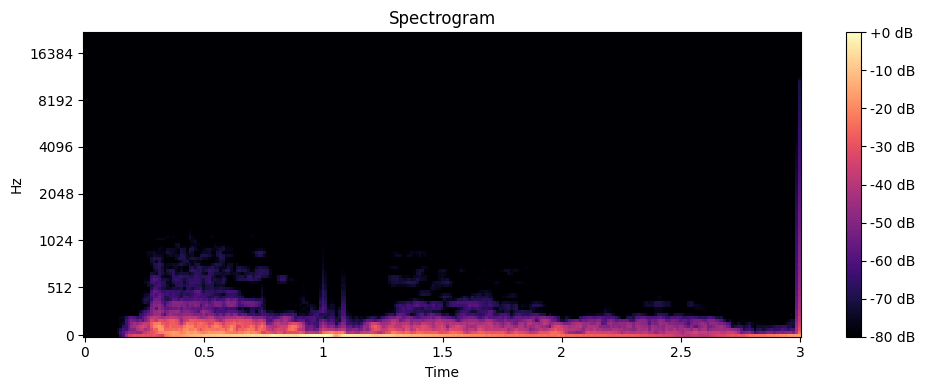

In [7]:
# Spectrogram of audio chunks
plot_melspectrogram_chunks(y=x, sr=sr)

In [8]:
# Load and preprocess data
def load_and_preprocess_data(data_dir, classes, target_shape=(150, 150)):
    data = []
    labels = []

    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print("Processing --", class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                try:
                    audio_data, sample_rate = librosa.load(file_path, sr=None)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                chunk_duration = 4  # seconds
                overlap_duration = 2  # seconds
                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate
                num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

                for i in range(num_chunks):
                    start = i * (chunk_samples - overlap_samples)
                    end = start + chunk_samples
                    chunk = audio_data[start:end]
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                    data.append(mel_spectrogram)
                    labels.append(i_class)

    return np.array(data), np.array(labels)

In [9]:
# Define your folder structure
data_dir = r'D:\Tag\Musical_Instruments_Classification\music_dataset'
classes = ['Accordion','Acoustic_Guitar','Banjo','Bass_Guitar','Clarinet','cowbell','Cymbals','Dobro','Drum_set','Electro_Guitar','Floor_Tom','flute','Harmonica','Harmonium','Hi_Hats','Horn','Keyboard','Mandolin','Organ','Piano','Saxophone','Shakers','Tambourine','Trombone','Trumpet','Ukulele','vibraphone','Violin']

In [10]:
# Load and preprocess the data
data, labels = load_and_preprocess_data(data_dir, classes)

Processing -- Accordion
Processing -- Acoustic_Guitar
Processing -- Banjo
Processing -- Bass_Guitar
Processing -- Clarinet
Processing -- cowbell
Processing -- Cymbals
Processing -- Dobro
Processing -- Drum_set
Processing -- Electro_Guitar
Processing -- Floor_Tom
Processing -- flute
Processing -- Harmonica
Processing -- Harmonium
Processing -- Hi_Hats
Processing -- Horn
Processing -- Keyboard
Processing -- Mandolin
Processing -- Organ
Processing -- Piano
Processing -- Saxophone
Processing -- Shakers
Processing -- Tambourine
Processing -- Trombone
Processing -- Trumpet
Processing -- Ukulele
Processing -- vibraphone
Processing -- Violin


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [12]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))

In [20]:
model = tf.keras.models.Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Dropout(0.3))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units=1200, activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(units=len(classes), activation='softmax'))

c:\Users\anand\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
# Train the model
training_history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 697s 656ms/step - accuracy: 0.4321 - loss: 2.0830 - val_accuracy: 0.7646 - val_loss: 0.8340
Epoch 2/30
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 680s 643ms/step - accuracy: 0.8098 - loss: 0.6374 - val_accuracy: 0.8861 - val_loss: 0.3809
Epoch 3/30
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 684s 647ms/step - accuracy: 0.8801 - loss: 0.3914 - val_accuracy: 0.9127 - val_loss: 0.2856
Epoch 4/30
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 660s 624ms/step - accuracy: 0.9153 - loss: 0.2768 - val_accuracy: 0.9403 - val_loss: 0.1995
Epoch 5/30
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 680s 642ms/step - accuracy: 0.9278 - loss: 0.2303 - val_accuracy: 0.9465 - val_loss: 0.1767
Epoch 6/30
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 668s 631ms/step - accuracy: 0.9463 - loss: 0.1689 - val_accuracy: 0.9560 - val_loss: 0.1468
Epoch 7/30
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 657s 621ms/step - accuracy: 0.9553 - loss: 0.1426 - val_accuracy: 0.9559 - val_loss: 0.1499
Epoch 8/30
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 671s 634ms/step - ac

In [25]:
# Save the model
model.save("Trained_model.h5")

In [26]:
train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Train Accuracy: {train_accuracy[1]}")
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy[1]}")

Train Accuracy: 0.9898664355278015
Test Accuracy: 0.9747134447097778


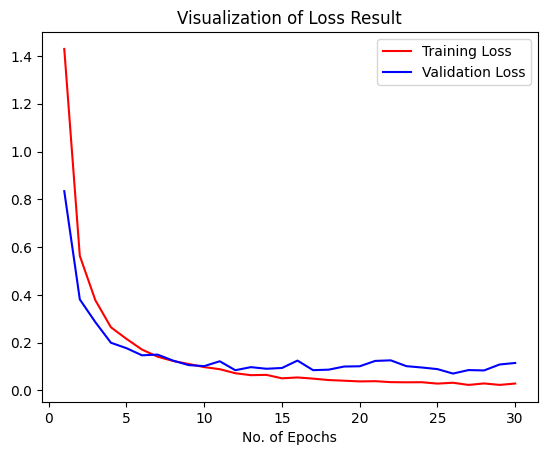

In [27]:
# Visualization of Loss
epochs = [i for i in range(1, 31)]
plt.plot(epochs, training_history.history['loss'], color='red', label='Training Loss')
plt.plot(epochs, training_history.history['val_loss'], color='blue', label='Validation Loss')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Loss Result')
plt.legend()
plt.show()

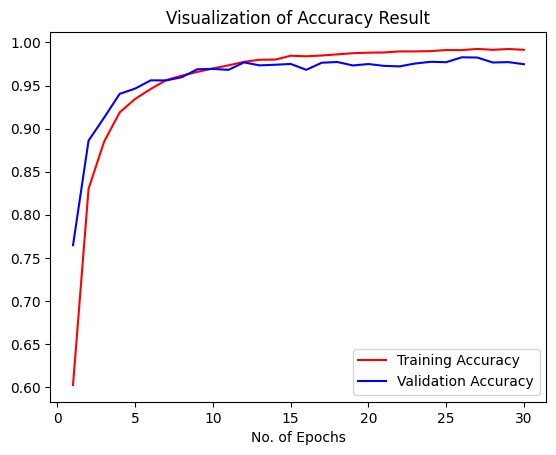

In [28]:
# Accuracy Visualization
plt.plot(epochs, training_history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(epochs, training_history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
# Prediction and evaluation
y_pred = model.predict(X_test)
predicted_categories = np.argmax(y_pred, axis=1)
true_categories = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(true_categories, predicted_categories, target_names=classes))


265/265 ━━━━━━━━━━━━━━━━━━━━ 47s 176ms/step
                 precision    recall  f1-score   support

      Accordion       0.98      0.99      0.99       750
Acoustic_Guitar       0.98      0.98      0.98       747
          Banjo       0.97      0.98      0.98       605
    Bass_Guitar       1.00      1.00      1.00       709
       Clarinet       0.94      0.94      0.94       113
        cowbell       1.00      1.00      1.00       121
        Cymbals       0.94      0.64      0.76        47
          Dobro       0.96      0.96      0.96        91
       Drum_set       1.00      1.00      1.00       711
 Electro_Guitar       0.98      0.98      0.98       267
      Floor_Tom       0.82      0.98      0.89        86
          flute       1.00      1.00      1.00       727
      Harmonica       0.89      0.93      0.91        27
      Harmonium       1.00      1.00      1.00       265
        Hi_Hats       0.89      0.91      0.90        82
           Horn       1.00      1.00      1

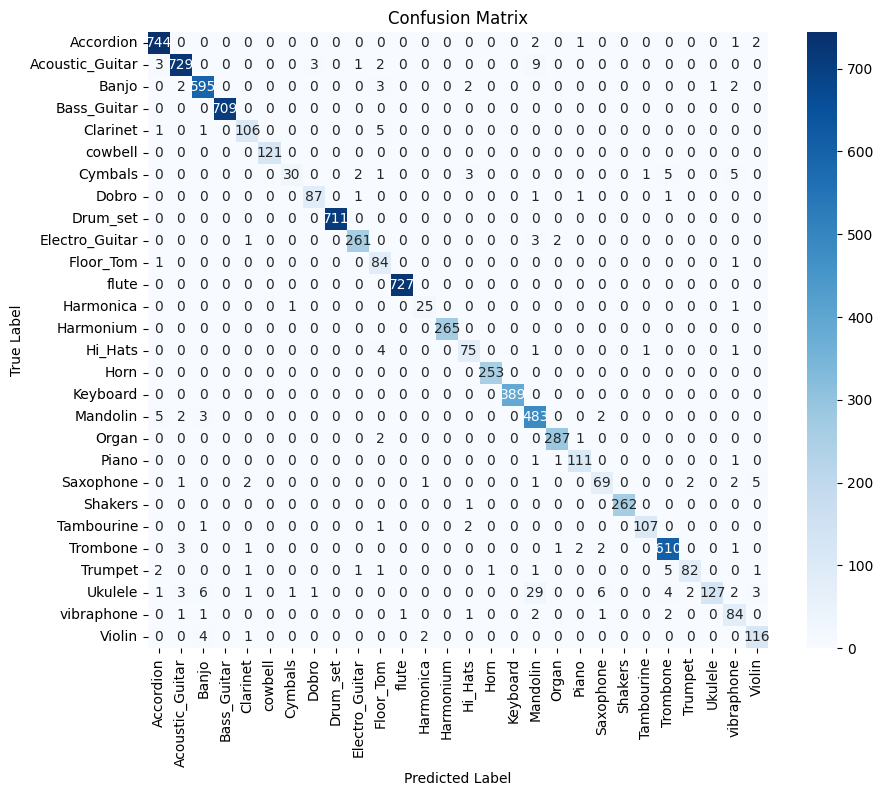

In [34]:
cm = confusion_matrix(true_categories, predicted_categories)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()